In [1]:
# Import basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose


plt.style.use('bmh')

%matplotlib inline 

In [84]:
path = r'C:\Users\xiand\Desktop\PropTech Challenge 2020\PropTech Challenge 2020 Data'
electric = pd.read_excel(path + '\ConEd_Electric.xlsx')
electric['date_time'] = pd.to_datetime(electric['date_time'])
date_time = pd.DataFrame(pd.date_range('2018-01-01 00:15:00', '2020-09-01', freq='15T'), columns=['date_time'])
electric = pd.merge(date_time, electric, on='date_time', how='left')
electric = electric.drop(['min_demand', 'avg_demand'], axis=1).rename(columns={'max_demand': 'demand'})

steam = pd.read_excel(path + '\ConEd_Steam.xlsx')
steam['date_time'] = pd.to_datetime(steam['date_time'])
steam = pd.merge(date_time, steam, on='date_time', how='left')
steam = steam.drop(['min_demand', 'avg_demand'], axis=1).rename(columns={'max_demand': 'demand'})
steam['temp'] = steam['temp'].interpolate(limit_direction='both')
steam['humidity'] = steam['humidity'].interpolate(limit_direction='both')

occupancy = pd.read_excel(path + '\Occupancy.xlsx')
date = pd.DataFrame(pd.date_range('2020-02-10', '2020-08-31'), columns=['date'])
occupancy = pd.merge(date, occupancy, on='date', how='left')

In [3]:
tenant_usage = pd.ExcelFile(path + '\Tenant_Usage.xlsx')

tenant_usage_meters = tenant_usage.parse('Meters')
tenant_usage_meters['Floor'] = tenant_usage_meters['Location'].str.extract('(\d+)')
tenant_usage_meters['Direction'] = tenant_usage_meters['Location'].apply(lambda x: 'South' if 'South' in x else 'North' if 'North' in x else '')
tenant_usage_meters['Other'] = tenant_usage_meters['Location'].apply(lambda x: 'HP' if 'HP' in x else 'LP' if 'LP' in x else 'LVP' if 'LVP' in x else '')


tenants = []
for i in range(1, 19):
    df = tenant_usage.parse(tenant_usage.sheet_names[i])
    df['date_time'] = pd.to_datetime(df['date_time'])
    date_time = pd.DataFrame(pd.date_range('2018-01-01 00:15:00', '2020-08-30 23:45:00', freq='15T'), columns=['date_time'])
    df = pd.merge(date_time, df, on='date_time', how='left')
    df['consumption'] = df['consumption'].abs()
    df = df.drop(['min_demand', 'avg_demand'], axis=1).rename(columns={'max_demand': 'demand'})
    df['cum_consumption'] = df['consumption'].fillna(0).cumsum()
    tenants.append(df)

In [57]:
tenant_usage_meters.to_csv('tenant_usage_meters.csv', index=False)

In [93]:
merge_data = electric.rename(columns={'consumption': 'electric_consumption', 'demand': 'electric_demand'}).drop(['temp', 'humidity'], axis=1) \
            .merge(steam.rename(columns={'consumption': 'steam_consumption', 'demand': 'steam_demand'}), on='date_time', how='outer') 

merge_data['electric_cum_consumption'] = merge_data['electric_consumption'].fillna(0).cumsum()
merge_data['electric_cum_demand'] = merge_data['electric_demand'].fillna(0).cumsum()

merge_data['steam_cum_consumption'] = merge_data['steam_consumption'].fillna(0).cumsum()
merge_data['steam_cum_demand'] = merge_data['steam_demand'].fillna(0).cumsum()

for i in range(18):
    merge_data = merge_data.merge(tenants[i].rename(columns={'consumption': 'tenant_'+str(i+1)+'_consumption', 'cum_consumption': 'tenant_'+str(i+1)+'_cum_consumption', 'demand': 'tenant_'+str(i+1)+'_demand'}).drop('meter', axis=1), 
                                  on='date_time', how='outer')

merge_data['all_tenants_consumption'] = 0
for i in range(1, 19):
    merge_data['all_tenants_consumption'] = merge_data['all_tenants_consumption'] + merge_data['tenant_'+str(i)+'_consumption'].fillna(0)
merge_data['all_tenants_cum_consumption'] = merge_data['all_tenants_consumption'].fillna(0).cumsum()

merge_data['date'] = pd.to_datetime(merge_data['date_time'].dt.strftime('%Y-%m-%d'))
merge_data = merge_data.merge(occupancy, on='date', how='outer')

merge_data = merge_data.set_index('date_time')
merge_data

electric_consumption  electric_demand  steam_consumption  \
date_time                                                                       
2018-01-01 00:15:00                 430.0           1720.0             4800.0   
2018-01-01 00:30:00                 420.0           1700.0             4480.0   
2018-01-01 00:45:00                 440.0           1720.0             5350.0   
2018-01-01 01:00:00                 420.0           1720.0             5660.0   
2018-01-01 01:15:00                 420.0           1680.0             5660.0   
...                                   ...              ...                ...   
2020-08-31 23:00:00                 200.0            800.0                0.0   
2020-08-31 23:15:00                 200.0            800.0                0.0   
2020-08-31 23:30:00                 200.0            800.0                0.0   
2020-08-31 23:45:00                 200.0            800.0                0.0   
2020-09-01 00:00:00                 200.0            800.0                0.0   

                     steam_demand    temp  humidity  electric_cum_consumption  \
date_time                                                                       
2018-01-01 00:15:00       18700.0   9.000    56.100                     430.0   
2018-01-01 00:30:00       18560.0   9.000    56.100                     850.0   
2018-01-01 00:45:00       19660.0   9.000    56.100                    1290.0   
2018-01-01 01:00:00       22020.0   9.000    56.100                    1710.0   
2018-01-01 01:15:00       22640.0   8.975    56.125                    2130.0   
...                           ...     ...       ...                       ...   
2020-08-31 23:00:00           0.0  71.600    57.000                32642490.0   
2020-08-31 23:15:00           0.0  71.600    57.000                32642690.0   
2020-08-31 23:30:00           0.0  71.600    57.000                32642890.0   
2020-08-31 23:45:00           0.0  71.600    57.000                32643090.0   
2020-09-01 00:00:00           0.0  71.600    57.000                32643290.0   

                     electric_cum_demand  steam_cum_consumption  \
date_time                                                         
2018-01-01 00:15:00               1720.0                 4800.0   
2018-01-01 00:30:00               3420.0                 9280.0   
2018-01-01 00:45:00               5140.0                14630.0   
2018-01-01 01:00:00               6860.0                20290.0   
2018-01-01 01:15:00               8540.0                25950.0   
...                                  ...                    ...   
2020-08-31 23:00:00          112944390.0             64226860.0   
2020-08-31 23:15:00          112945190.0             64226860.0   
2020-08-31 23:30:00          112945990.0             64226860.0   
2020-08-31 23:45:00          112946790.0             64226860.0   
2020-09-01 00:00:00          112947590.0             64226860.0   

                     steam_cum_demand  ...  tenant_17_consumption  \
date_time                              ...                          
2018-01-01 00:15:00           18700.0  ...                    0.2   
2018-01-01 00:30:00           37260.0  ...                    0.2   
2018-01-01 00:45:00           56920.0  ...                    0.4   
2018-01-01 01:00:00           78940.0  ...                    0.4   
2018-01-01 01:15:00          101580.0  ...                    0.2   
...                               ...  ...                    ...   
2020-08-31 23:00:00       255003050.0  ...                    NaN   
2020-08-31 23:15:00       255003050.0  ...                    NaN   
2020-08-31 23:30:00       255003050.0  ...                    NaN   
2020-08-31 23:45:00       255003050.0  ...                    NaN   
2020-09-01 00:00:00       255003050.0  ...                    NaN   

                     tenant_17_demand  tenant_17_cum_consumption  \
date_time                                                          
2018-01

In [94]:
merge_data.to_csv('tenant_energy_clean_data.csv', index=True)

In [97]:
#pd.read_csv('tenant_energy_clean_data.csv').set_index('date_time')

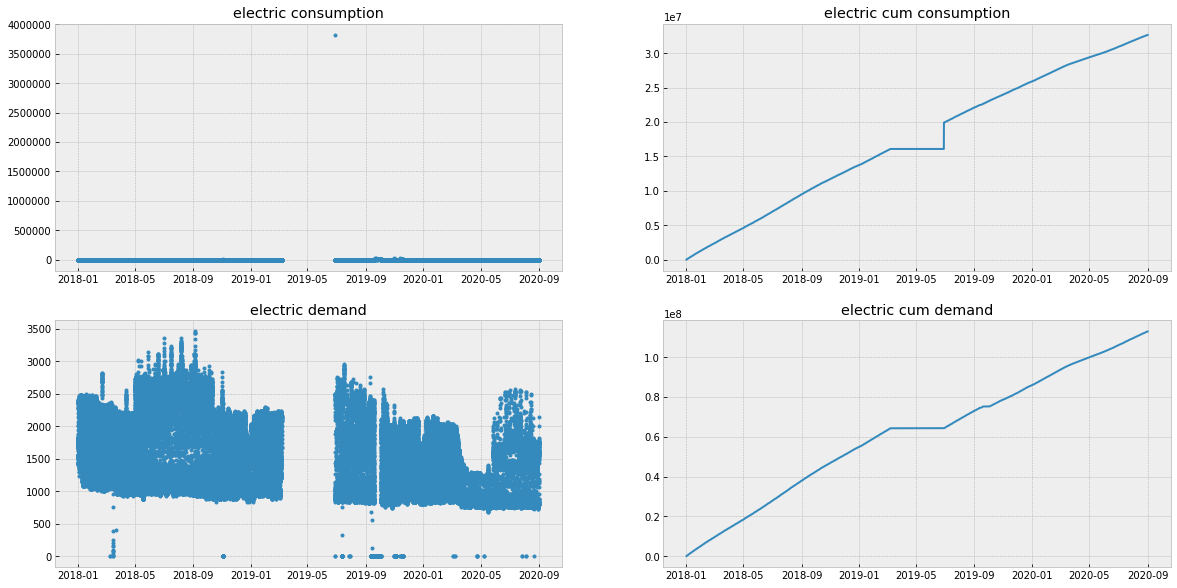

In [119]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0,0].plot(merge_data.index, merge_data['electric_consumption'], '.')
axs[0,0].set_title('electric consumption')
axs[0,1].plot(merge_data.index, merge_data['electric_cum_consumption'], '-')
axs[0,1].set_title('electric cum consumption')

axs[1,0].plot(merge_data.index, merge_data['electric_demand'], '.')
axs[1,0].set_title('electric demand')
axs[1,1].plot(merge_data.index, merge_data['electric_cum_demand'], '-')
axs[1,1].set_title('electric cum demand')
plt.show()

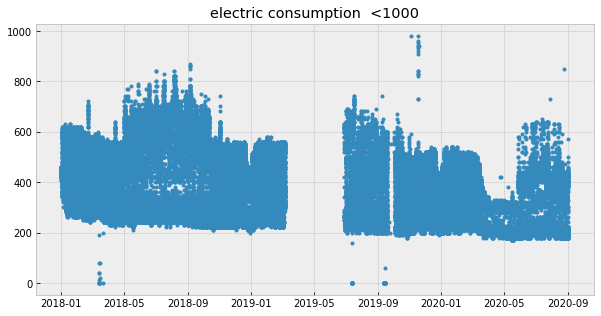

In [143]:
#df = merge_data[merge_data['electric_consumption']<merge_data['electric_consumption'].max()]
df = merge_data[merge_data['electric_consumption']<1000]

plt.figure(figsize=(10,5))
plt.plot(df.index, df['electric_consumption'], '.')
plt.title('electric consumption  <1000')
plt.show()

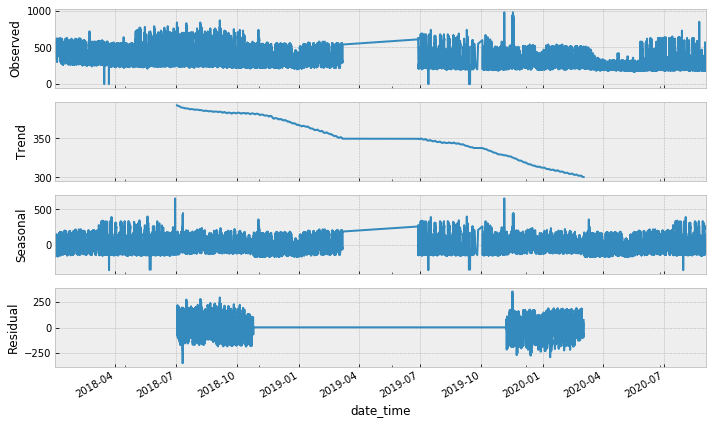

In [174]:
import pylab

pylab.rcParams['figure.figsize'] = (10, 6)
df = merge_data[merge_data['electric_consumption']<1000]
seasonal_decompose(df['electric_consumption'].fillna(0), freq=4*24*365).plot()
plt.show()

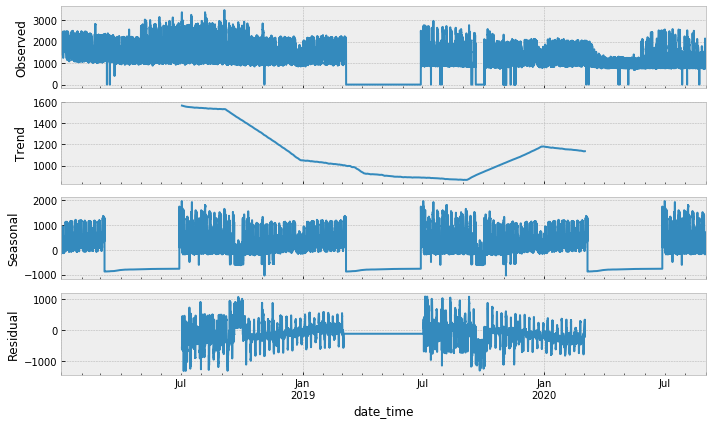

In [175]:
pylab.rcParams['figure.figsize'] = (10, 6)
seasonal_decompose(merge_data['electric_demand'].fillna(0), freq=4*24*365).plot()
plt.show()

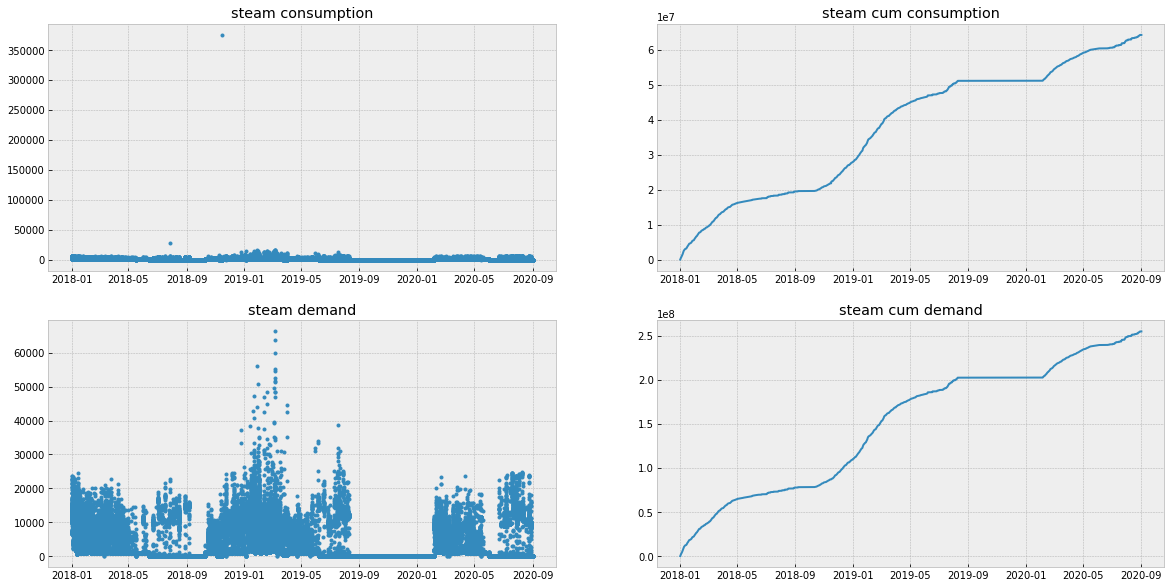

In [120]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0,0].plot(merge_data.index, merge_data['steam_consumption'], '.')
axs[0,0].set_title('steam consumption')
axs[0,1].plot(merge_data.index, merge_data['steam_cum_consumption'], '-')
axs[0,1].set_title('steam cum consumption')

axs[1,0].plot(merge_data.index, merge_data['steam_demand'], '.')
axs[1,0].set_title('steam demand')
axs[1,1].plot(merge_data.index, merge_data['steam_cum_demand'], '-')
axs[1,1].set_title('steam cum demand')
plt.show()

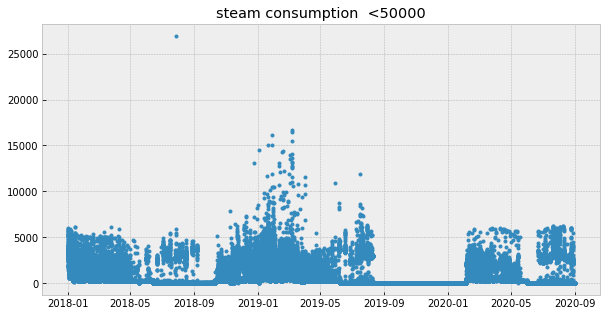

In [158]:
df = merge_data[merge_data['steam_consumption']<50000]
plt.figure(figsize=(10,5))
plt.plot(df.index, df['steam_consumption'], '.')
plt.title('steam consumption  <50000')
plt.show()

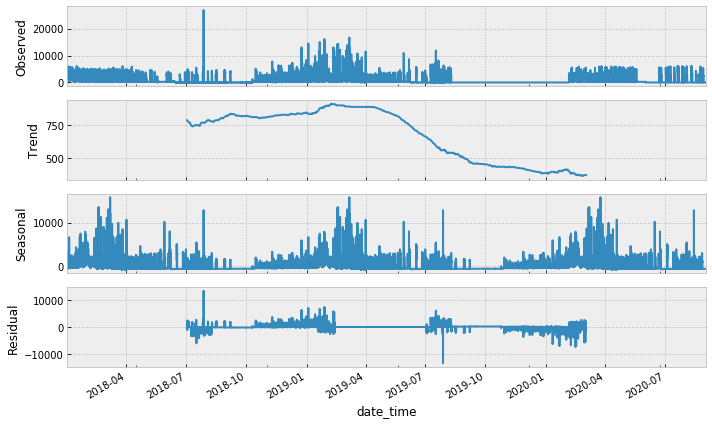

In [176]:
pylab.rcParams['figure.figsize'] = (10, 6)
df = merge_data[merge_data['steam_consumption']<50000]
seasonal_decompose(df['steam_consumption'].fillna(0), freq=4*24*365).plot()
plt.show()

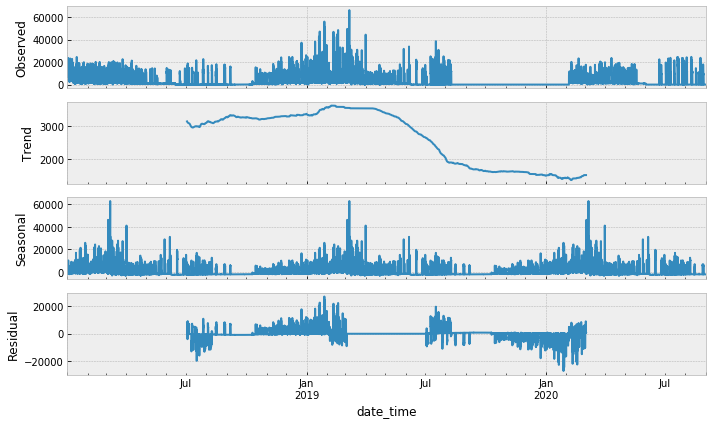

In [177]:
pylab.rcParams['figure.figsize'] = (10, 6)
seasonal_decompose(merge_data['steam_demand'].fillna(0), freq=4*24*365).plot()
plt.show()

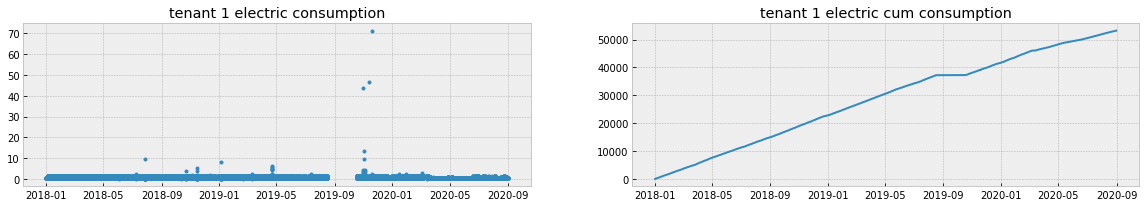

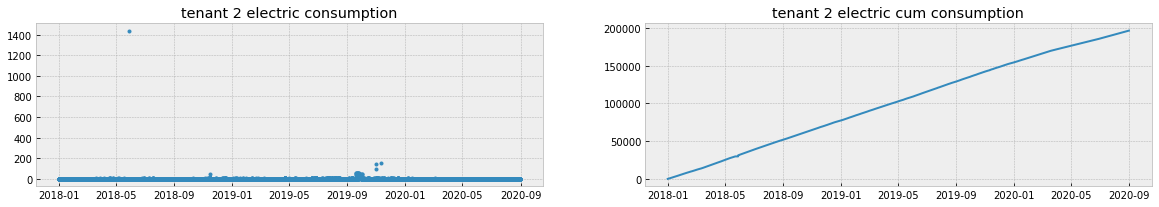

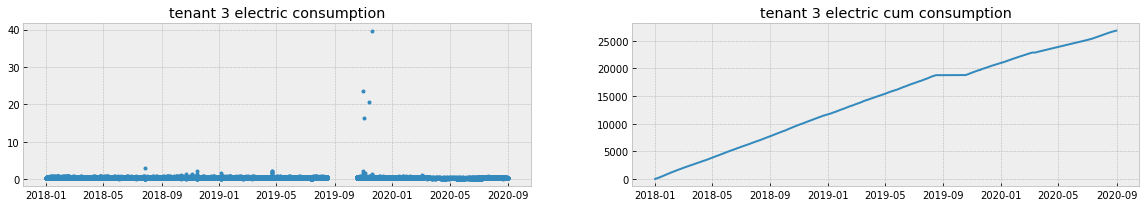

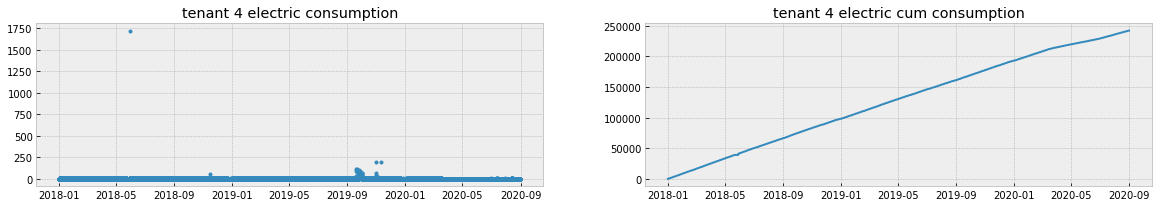

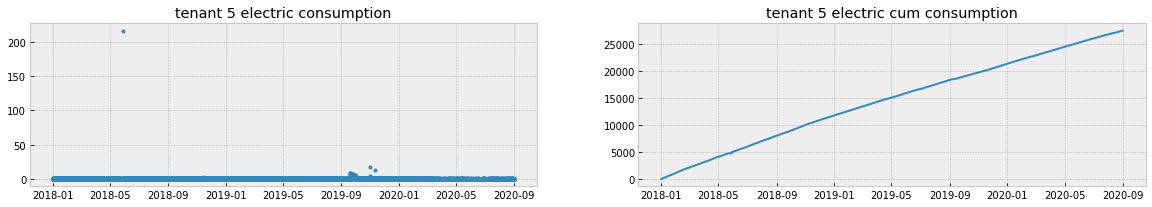

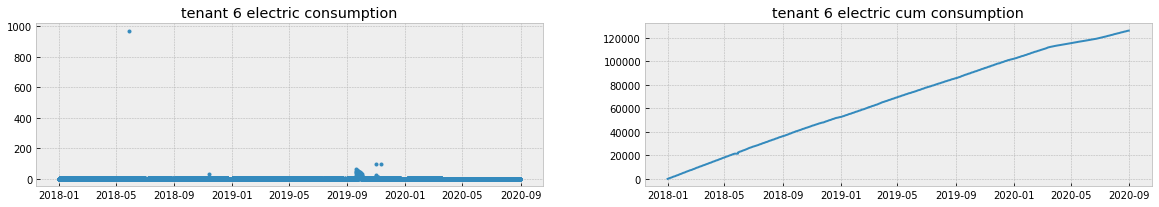

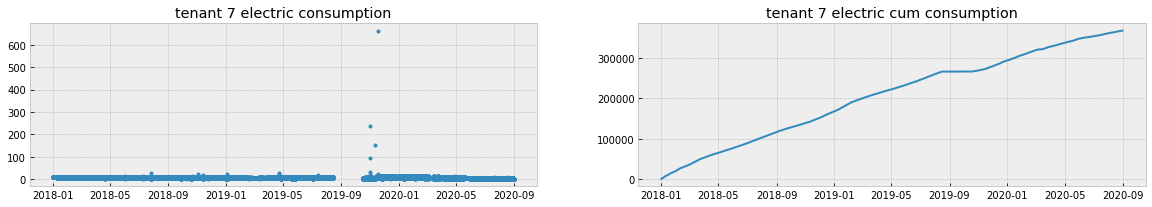

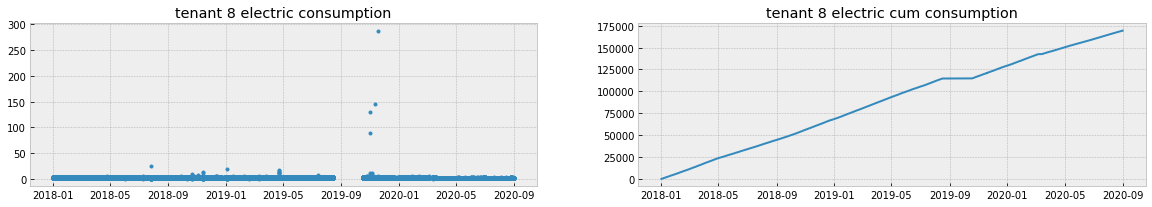

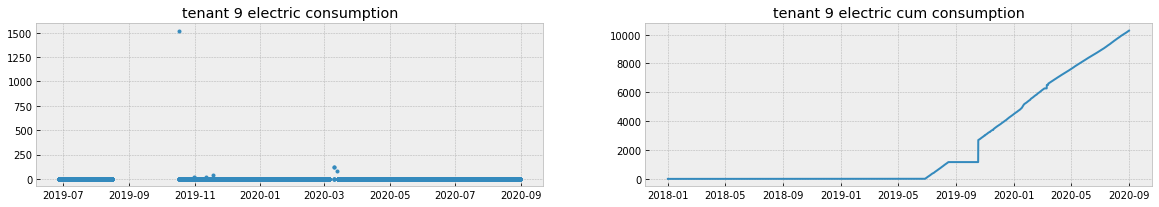

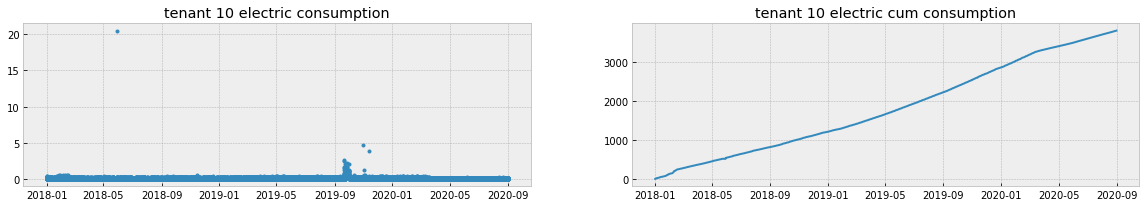

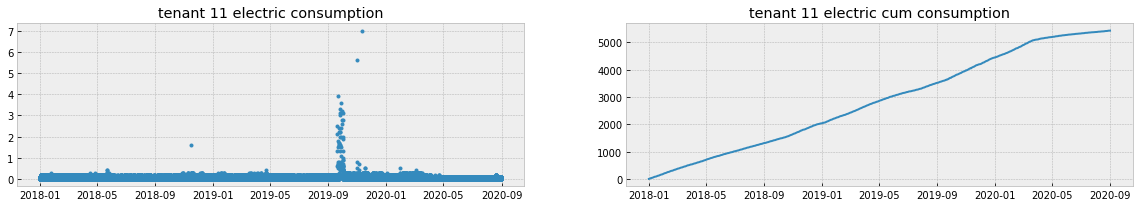

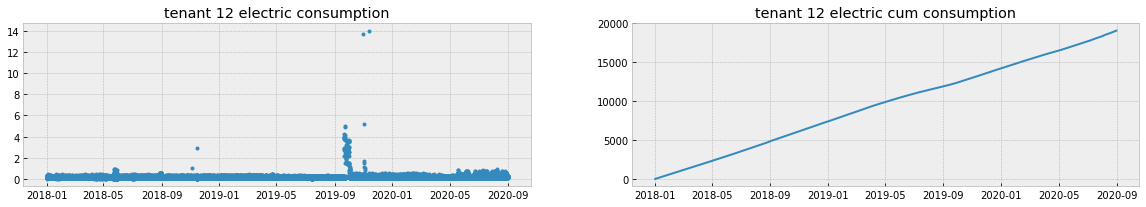

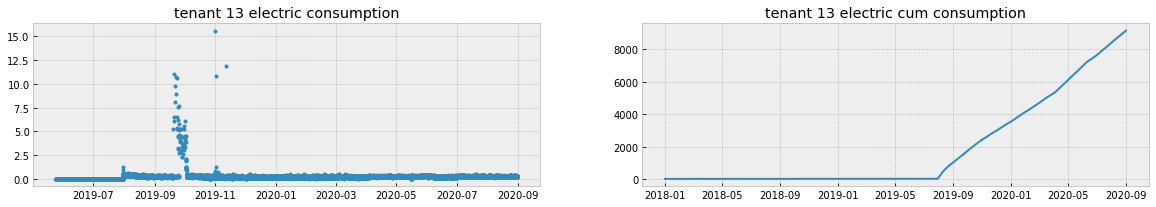

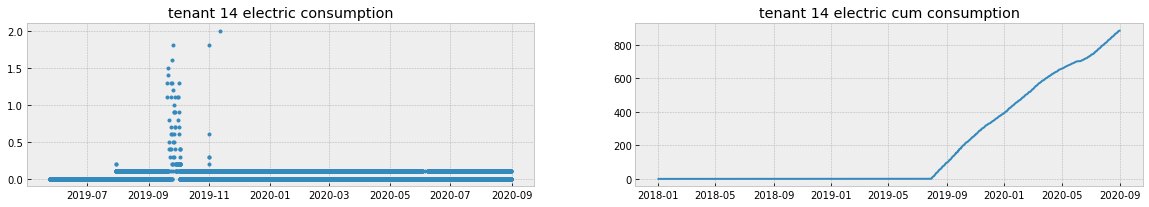

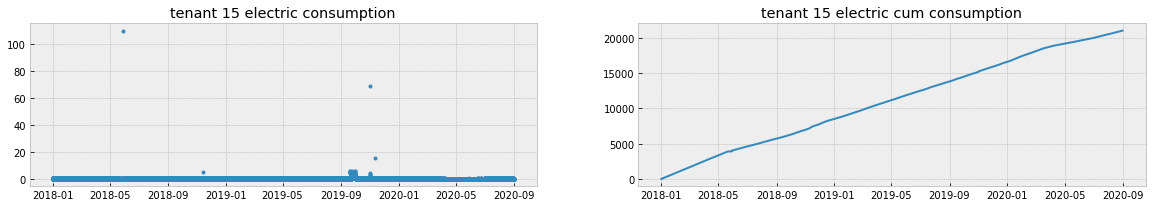

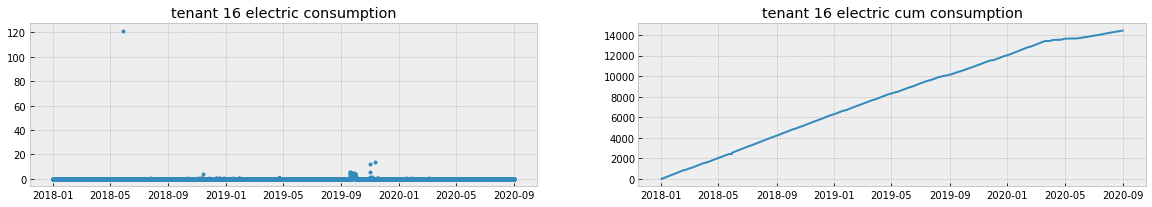

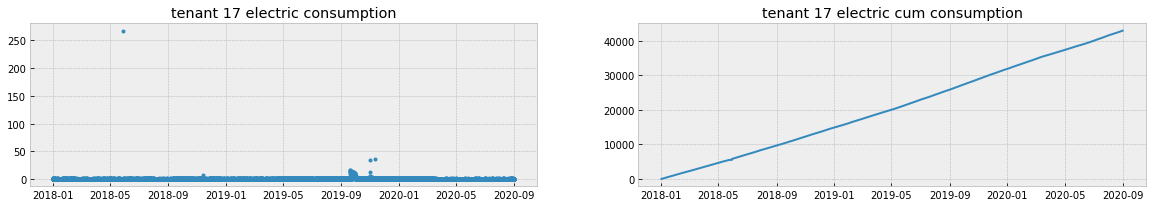

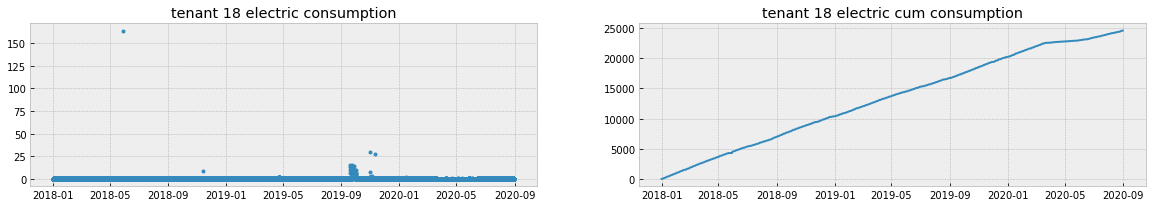

In [165]:
for i in range(1,19):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 3))
    ax1.plot(merge_data.index, merge_data['tenant_'+str(i)+'_consumption'], '.')
    ax1.set_title('tenant '+str(i)+' electric consumption')
    ax2.plot(merge_data.index, merge_data['tenant_'+str(i)+'_cum_consumption'], '-')
    ax2.set_title('tenant '+str(i)+' electric cum consumption')

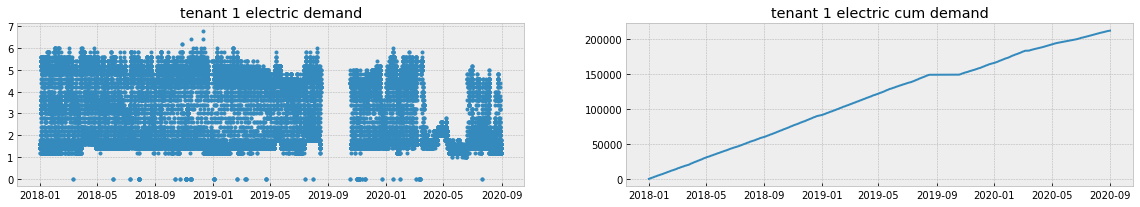

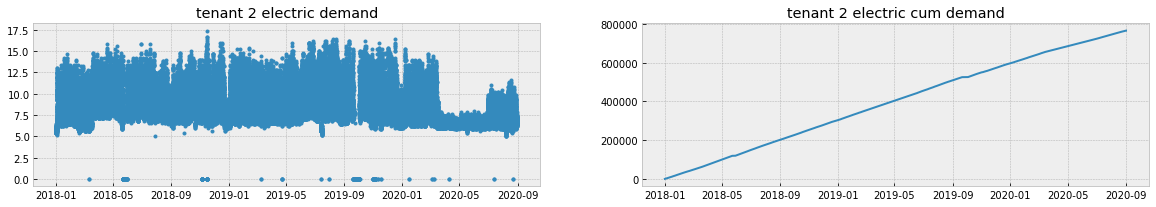

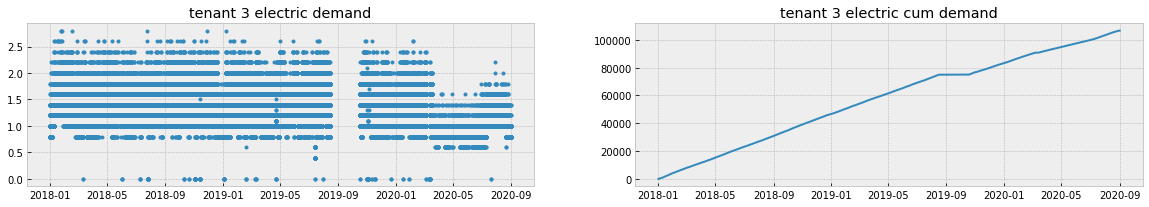

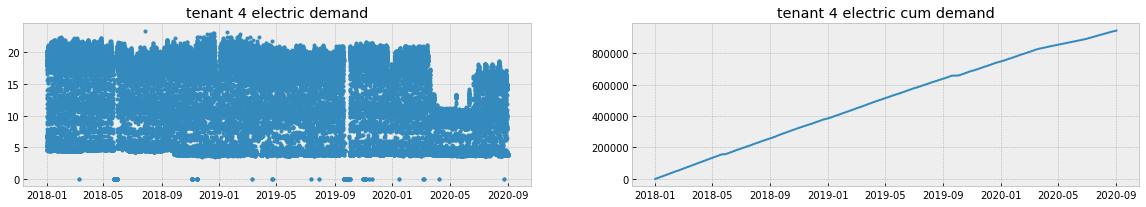

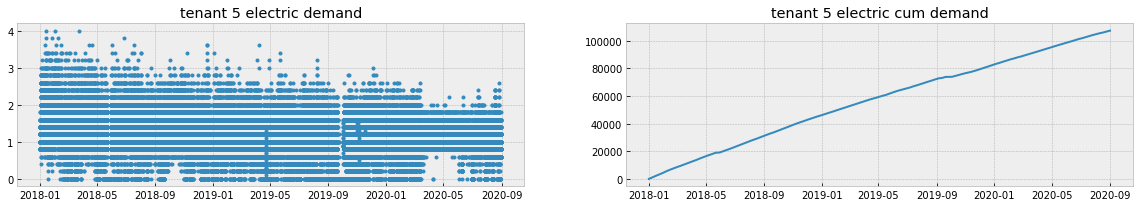

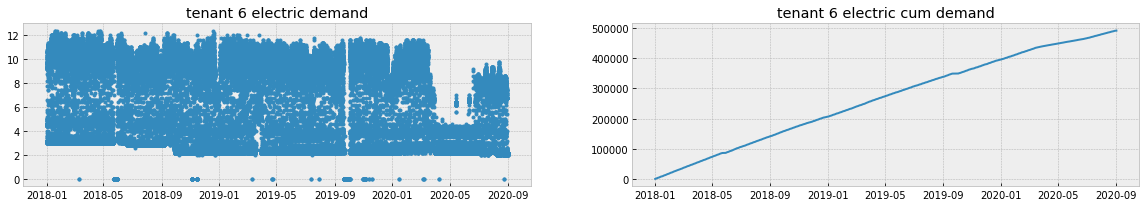

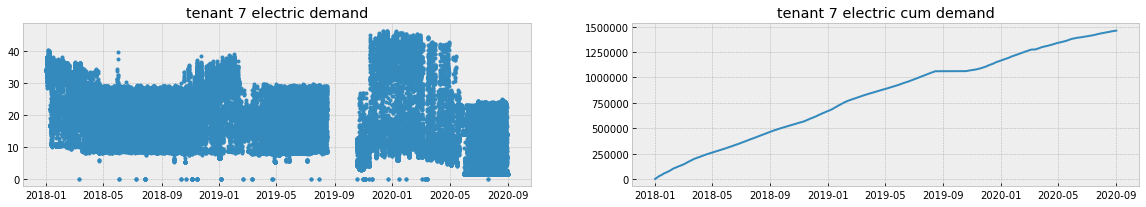

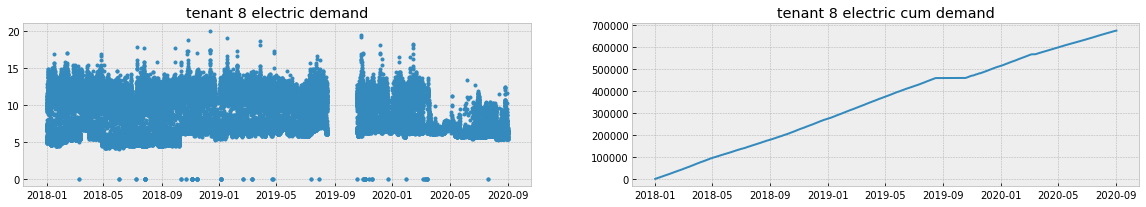

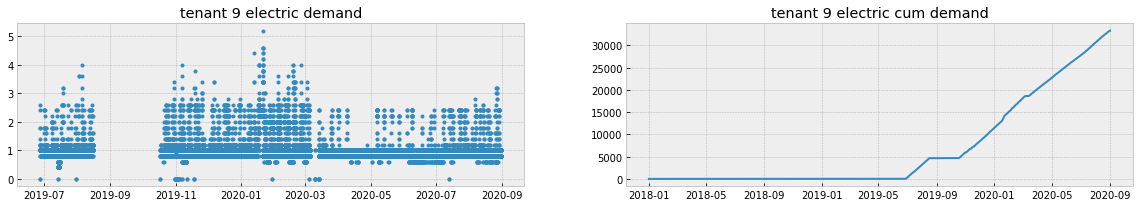

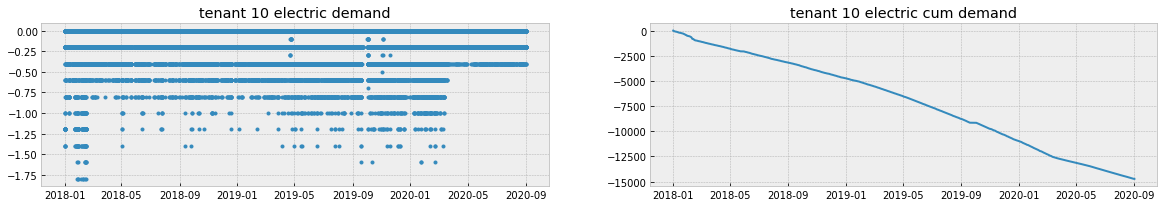

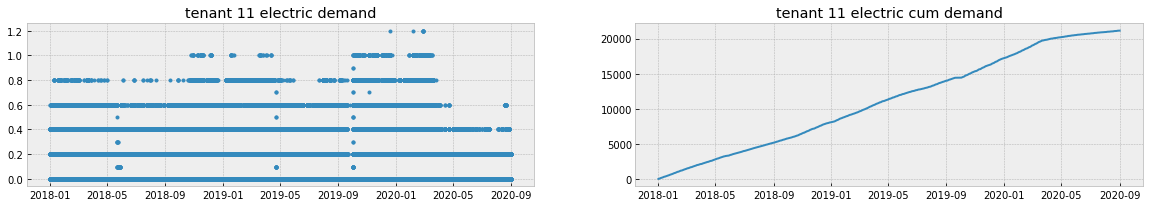

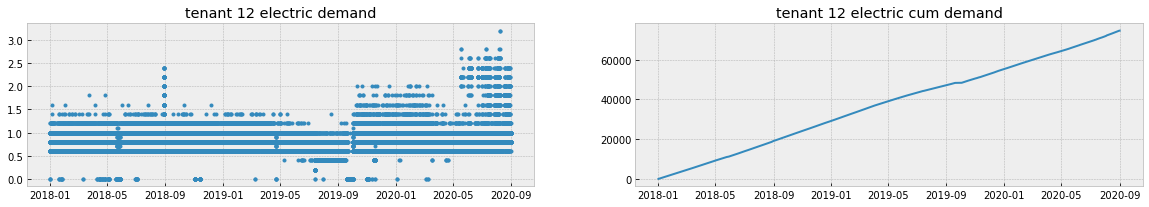

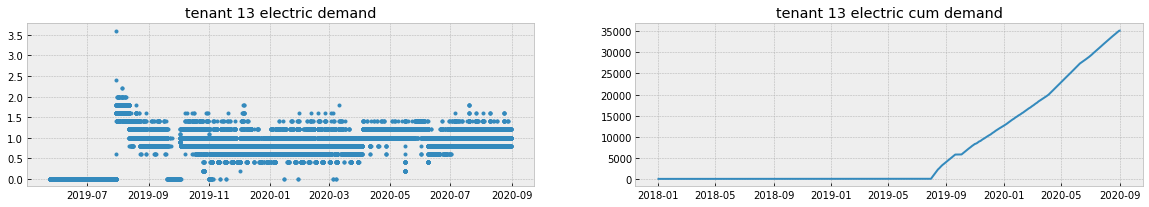

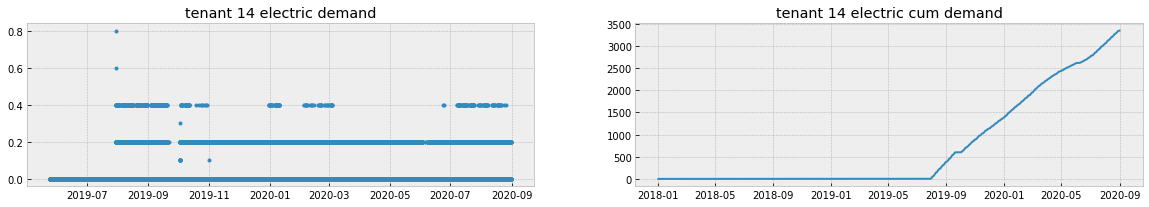

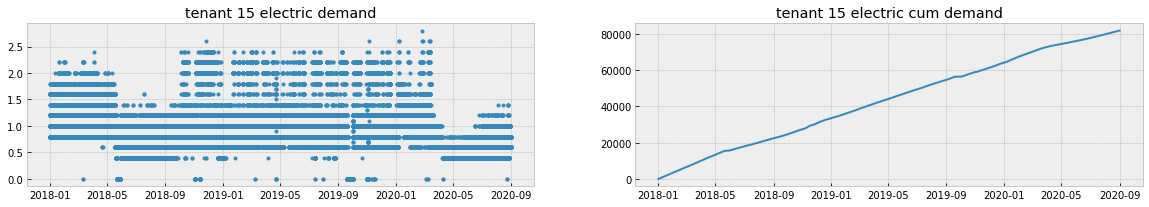

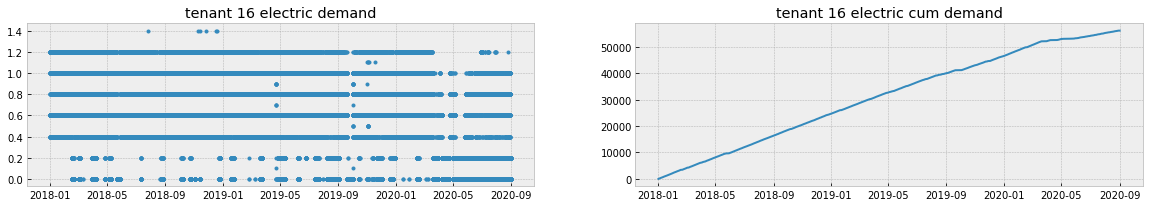

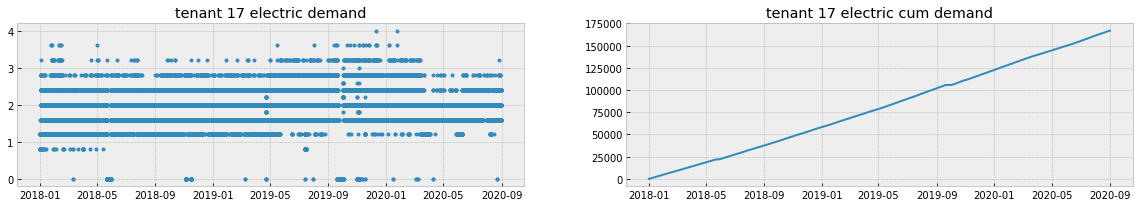

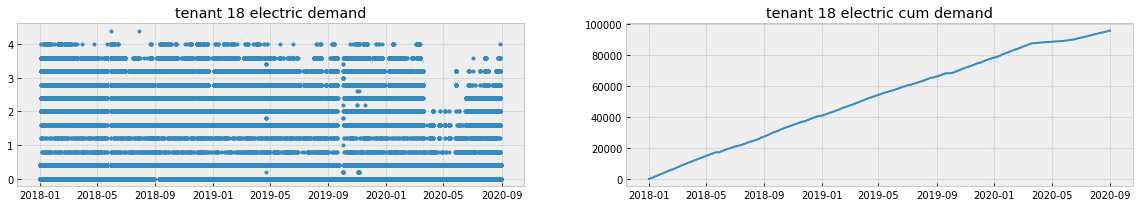

In [167]:
for i in range(1,19):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 3))
    ax1.plot(merge_data.index, merge_data['tenant_'+str(i)+'_demand'], '.')
    ax1.set_title('tenant '+str(i)+' electric demand')
    ax2.plot(merge_data.index, merge_data['tenant_'+str(i)+'_demand'].fillna(0).cumsum(), '-')
    ax2.set_title('tenant '+str(i)+' electric cum demand')

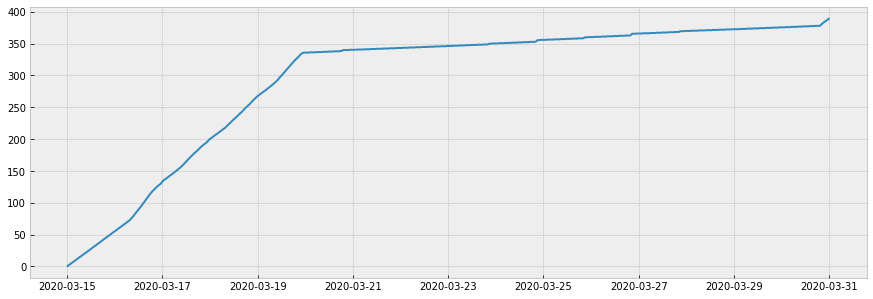

In [238]:
plt.figure(figsize=(15,5))
df = merge_data[(merge_data.index>'2020-03-15') & (merge_data.index<'2020-03-31')]
plt.plot(df.index, df['tenant_16_demand'].fillna(0).cumsum(), '-')
plt.show()

In [ ]:
'''for i in range(1,19):
    pylab.rcParams['figure.figsize'] = (10, 5)
    seasonal_decompose(merge_data['tenant_'+str(i)+'_demand'].fillna(0), freq=4*24*365).plot()
    plt.show()'''

In [194]:
merge_data['electric_consumption'].index>'2020-02-01'

array([False, False, False, ...,  True,  True,  True])

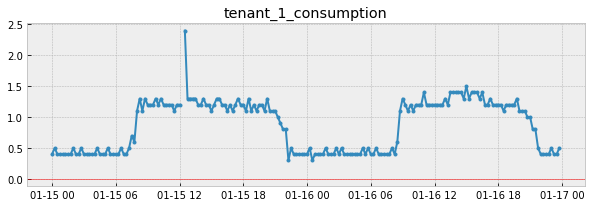

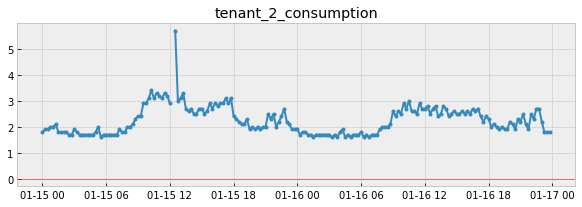

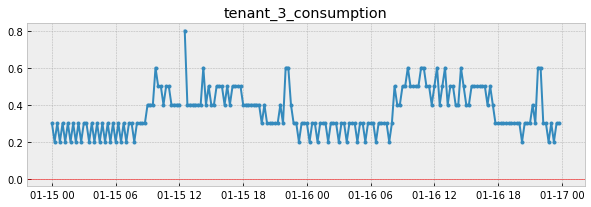

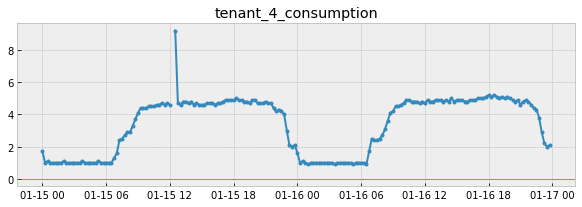

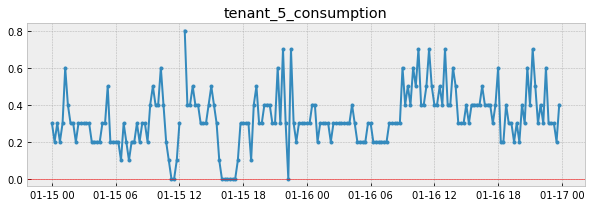

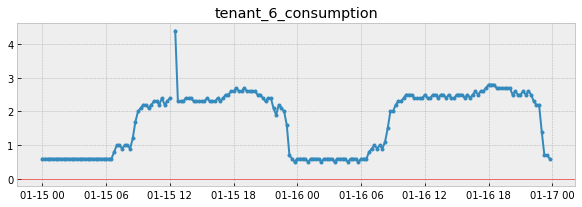

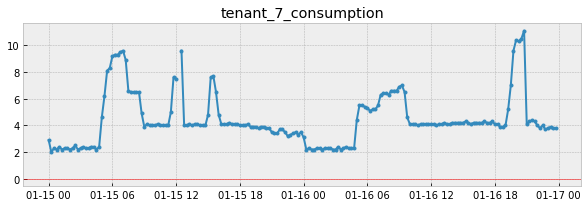

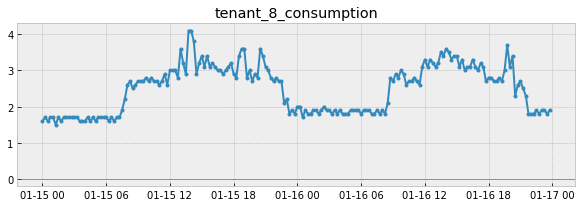

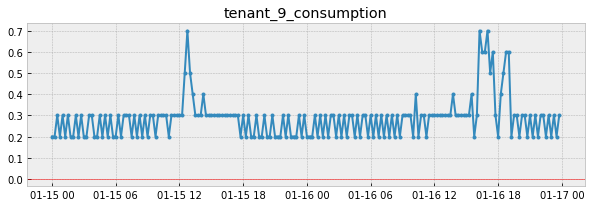

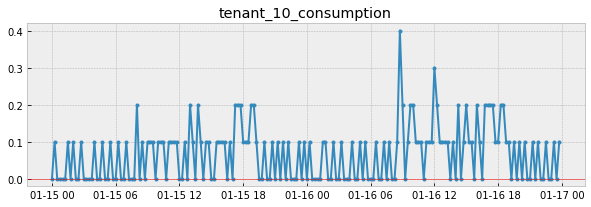

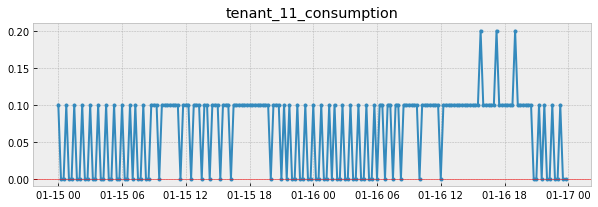

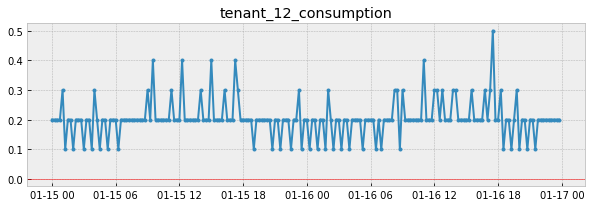

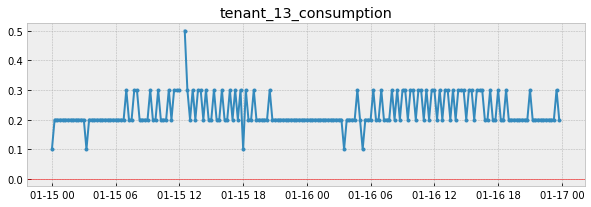

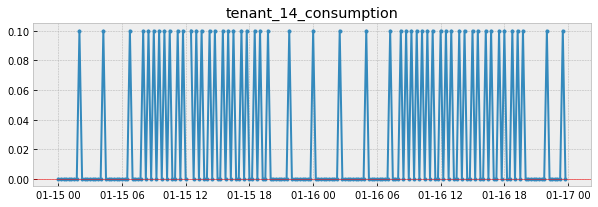

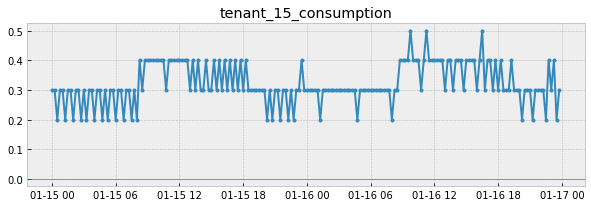

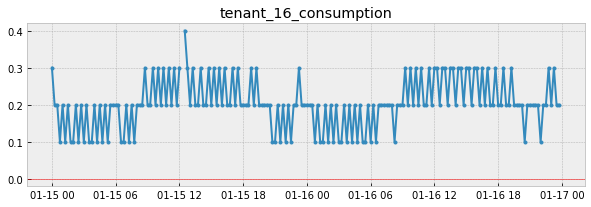

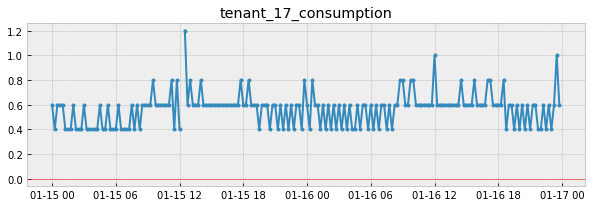

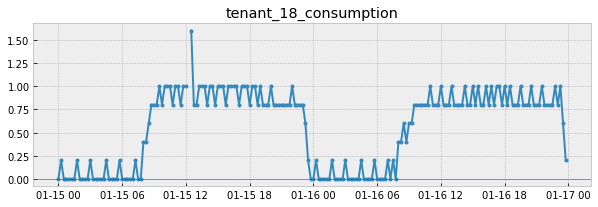

In [202]:
import random

idx = random.randint(0, len(merge_data))

for i in range(1,19):
    plt.figure(figsize=(10,3))
    df = merge_data[merge_data.index>='2020-01-15']
    plt.plot(df.head(4*24*2).index, df['tenant_'+str(i)+'_consumption'].head(4*24*2), '.-')
    #plt.plot(merge_data.iloc[idx:idx+4*24*1].index, merge_data['tenant_'+str(i)+'_consumption'].iloc[idx:idx+4*24*1], '.-')
    plt.title('tenant_'+str(i)+'_consumption')
    plt.axhline(0, linewidth=0.5, color='r')

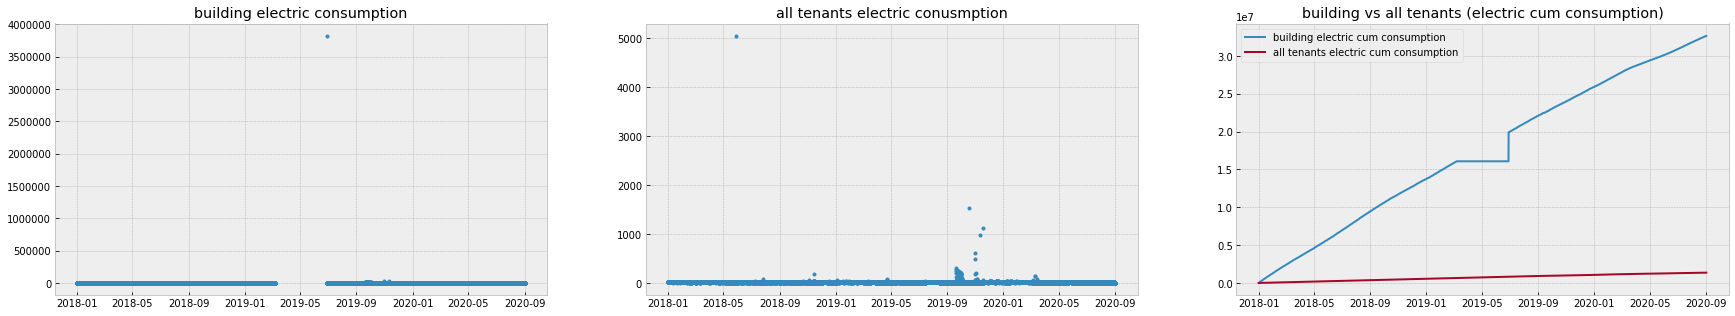

In [203]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,5))
ax1.plot(merge_data.index, merge_data['electric_consumption'], '.')
ax1.set_title('building electric consumption')
ax2.plot(merge_data.index, merge_data['all_tenants_consumption'], '.')
ax2.set_title('all tenants electric conusmption')
ax3.plot(merge_data.index, merge_data['electric_cum_consumption'], '-', label='building electric cum consumption')
ax3.plot(merge_data.index, merge_data['all_tenants_cum_consumption'], '-', label='all tenants electric cum consumption')
ax3.set_title('building vs all tenants (electric cum consumption)')
ax3.legend()

plt.show()

In [204]:
daily_consumption = merge_data.groupby(['date'])['electric_consumption', 'steam_consumption', 'all_tenants_consumption'].sum().reset_index()
daily_consumption = occupancy.merge(daily_consumption, on='date', how='outer')
daily_consumption.head()

date  entries  electric_consumption  steam_consumption  \
0 2020-02-10   1900.0               36720.0           179360.0   
1 2020-02-11      NaN               35640.0           129380.0   
2 2020-02-12      NaN               36160.0           149670.0   
3 2020-02-13      NaN               35640.0           154400.0   
4 2020-02-14      NaN               36080.0           206430.0   

   all_tenants_consumption  
0                   1815.9  
1                   1685.4  
2                   1760.6  
3                   1750.6  
4                   1778.3

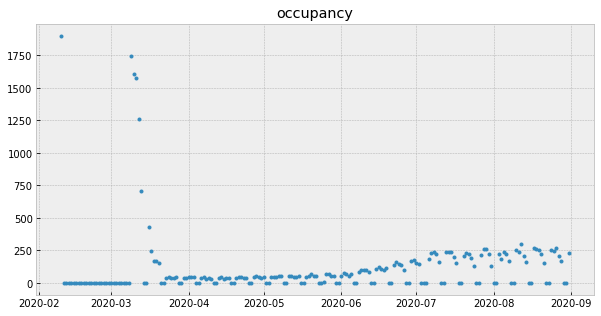

In [205]:
plt.figure(figsize=(10,5))
plt.plot(occupancy['date'], occupancy['entries'].fillna(0), '.')
plt.title('occupancy')
plt.show()

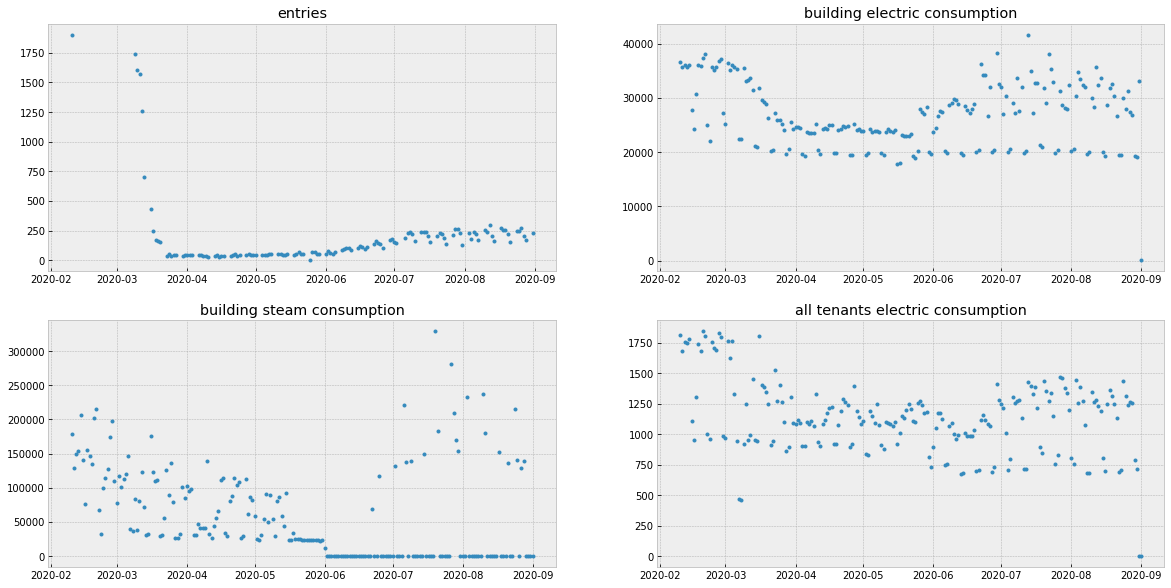

In [206]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
df = daily_consumption[daily_consumption['date'].dt.strftime('%Y-%m-%d')>='2020-02-10']

axs[0,0].plot(df['date'], df['entries'], '.')
axs[0,0].set_title('entries')
axs[0,1].plot(df['date'], df['electric_consumption'], '.')
axs[0,1].set_title('building electric consumption')
axs[1,0].plot(df['date'], df['steam_consumption'], '.')
axs[1,0].set_title('building steam consumption')
axs[1,1].plot(df['date'], df['all_tenants_consumption'], '.')
axs[1,1].set_title('all tenants electric consumption')
plt.show()

In [207]:
# not fillna
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [208]:
# fillna
corr = df.fillna(0).corr()
corr.style.background_gradient(cmap='coolwarm')

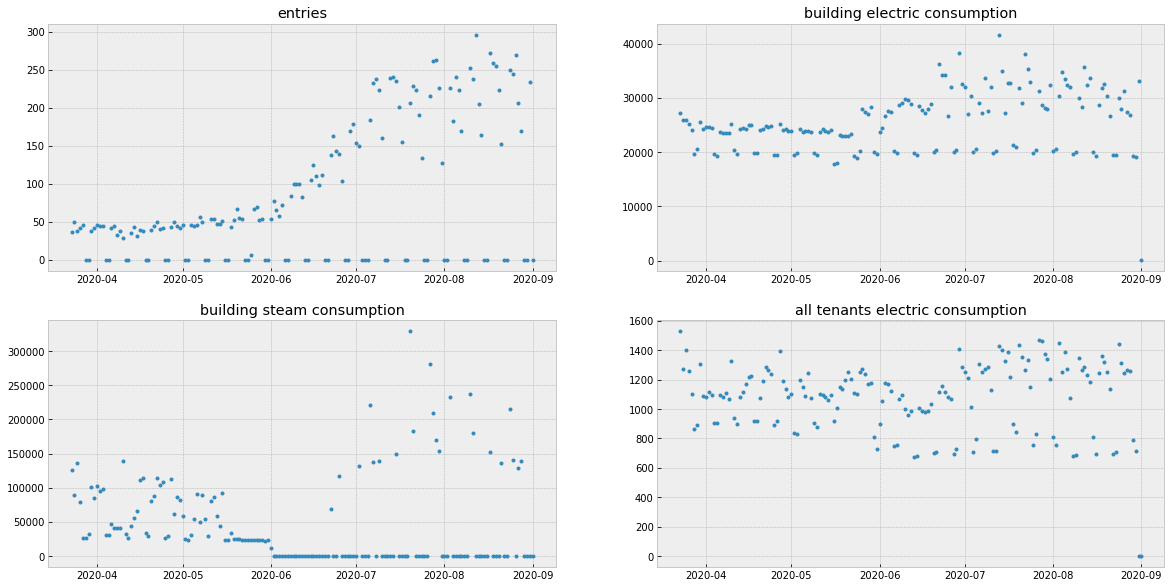

In [209]:
# shorten date range
fig, axs = plt.subplots(2,2, figsize=(20,10))
df = daily_consumption[daily_consumption['date'].dt.strftime('%Y-%m-%d')>='2020-03-23']

axs[0,0].plot(df['date'], df['entries'].fillna(0), '.')
axs[0,0].set_title('entries')
axs[0,1].plot(df['date'], df['electric_consumption'], '.')
axs[0,1].set_title('building electric consumption')
axs[1,0].plot(df['date'], df['steam_consumption'], '.')
axs[1,0].set_title('building steam consumption')
axs[1,1].plot(df['date'], df['all_tenants_consumption'], '.')
axs[1,1].set_title('all tenants electric consumption')
plt.show()

corr = df.fillna(0).corr()
corr.style.background_gradient(cmap='coolwarm')

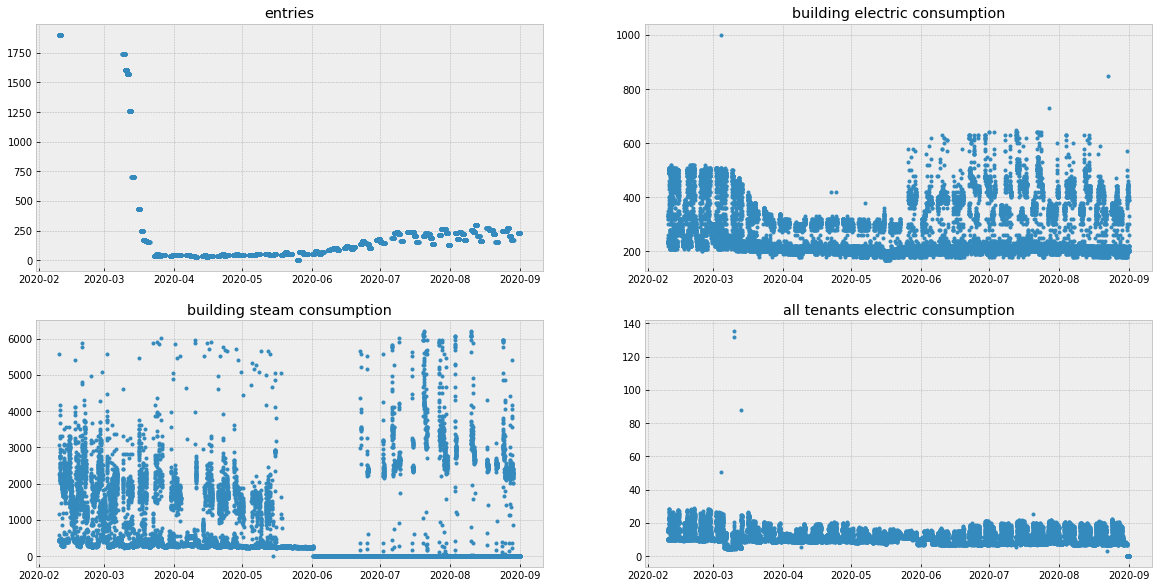

In [211]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
df = merge_data[merge_data['date'].dt.strftime('%Y-%m-%d')>='2020-02-10'][['entries', 'electric_consumption', 'steam_consumption', 'all_tenants_consumption']]

axs[0,0].plot(df.index, df['entries'], '.')
axs[0,0].set_title('entries')
axs[0,1].plot(df.index, df['electric_consumption'], '.')
axs[0,1].set_title('building electric consumption')
axs[1,0].plot(df.index, df['steam_consumption'], '.')
axs[1,0].set_title('building steam consumption')
axs[1,1].plot(df.index, df['all_tenants_consumption'], '.')
axs[1,1].set_title('all tenants electric consumption')
plt.show()

corr = df.fillna(0).corr()
corr.style.background_gradient(cmap='coolwarm')

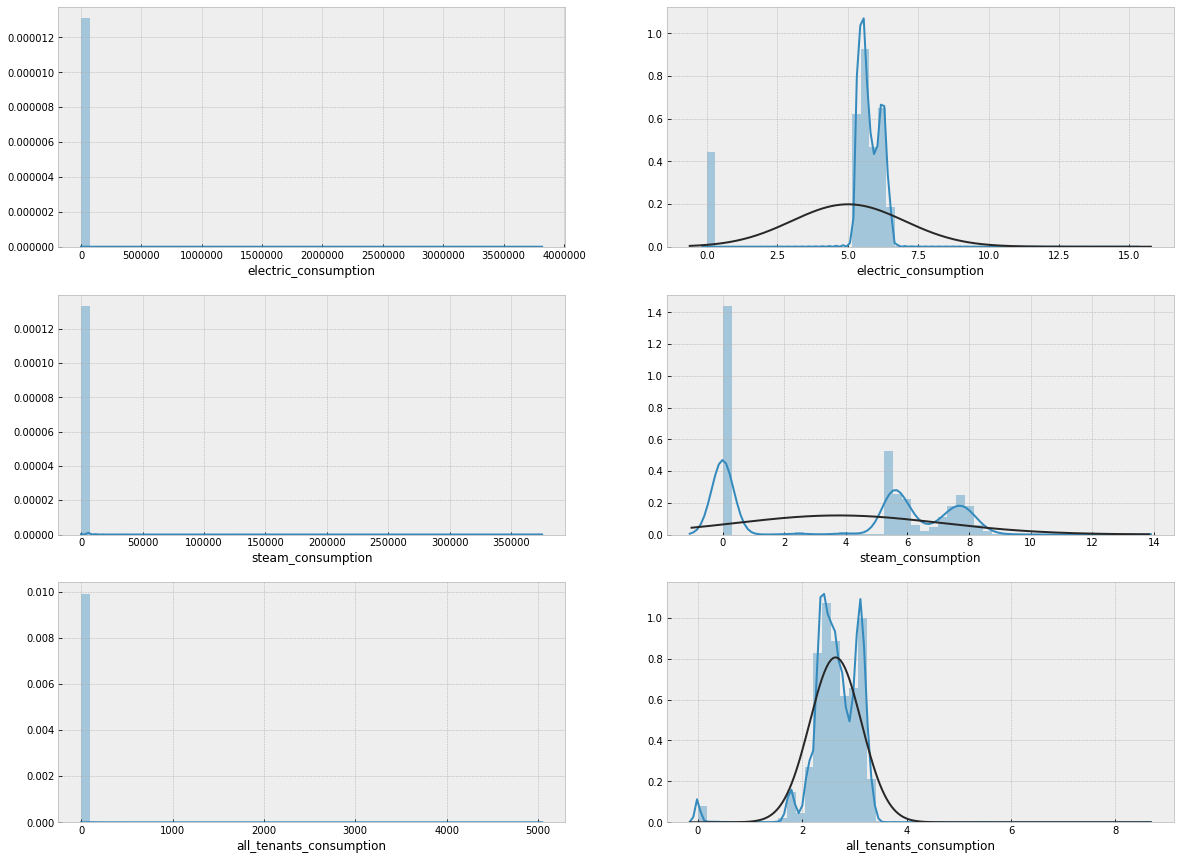

In [212]:
fig, axs = plt.subplots(3,2, figsize=(20,15))
sns.distplot(merge_data['electric_consumption'].fillna(0), ax=axs[0, 0])
sns.distplot(np.log1p(merge_data['electric_consumption'].fillna(0)), fit=norm, ax=axs[0, 1])
sns.distplot(merge_data['steam_consumption'].fillna(0), ax=axs[1, 0])
sns.distplot(np.log1p(merge_data['steam_consumption'].fillna(0)), fit=norm, ax=axs[1, 1])
sns.distplot(merge_data['all_tenants_consumption'].fillna(0), ax=axs[2, 0])
sns.distplot(np.log1p(merge_data['all_tenants_consumption'].fillna(0)), fit=norm, ax=axs[2, 1])
plt.show()

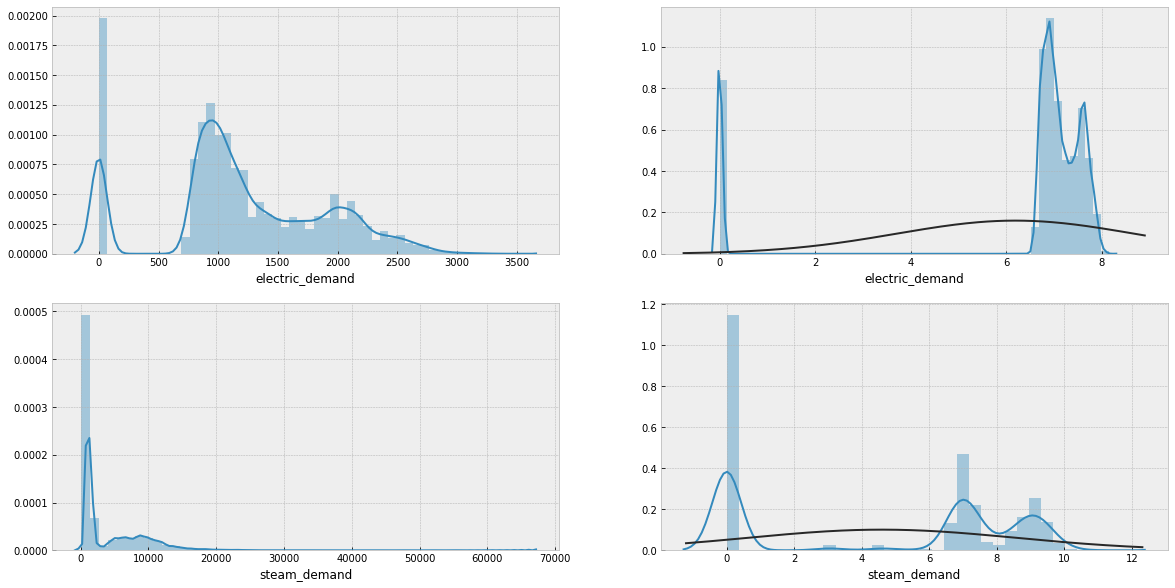

In [217]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
sns.distplot(merge_data['electric_demand'].fillna(0), ax=axs[0, 0])
sns.distplot(np.log1p(merge_data['electric_demand'].fillna(0)), fit=norm, ax=axs[0, 1])
sns.distplot(merge_data['steam_demand'].fillna(0), ax=axs[1, 0])
sns.distplot(np.log1p(merge_data['steam_demand'].fillna(0)), fit=norm, ax=axs[1, 1])
#sns.distplot(merge_data['all_tenants_demand'].fillna(0), ax=axs[2, 0])
#sns.distplot(np.log1p(merge_data['all_tenants_demand'].fillna(0)), fit=norm, ax=axs[2, 1])
plt.show()

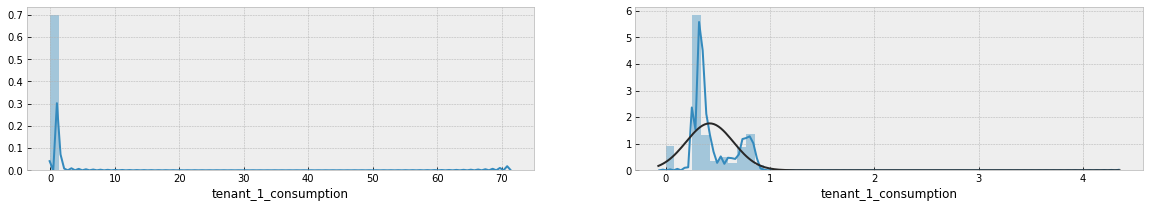

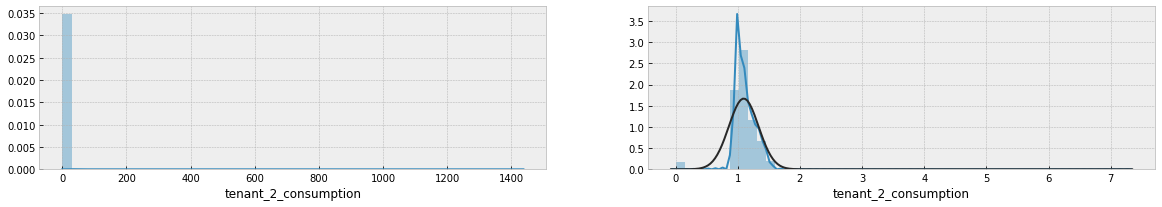

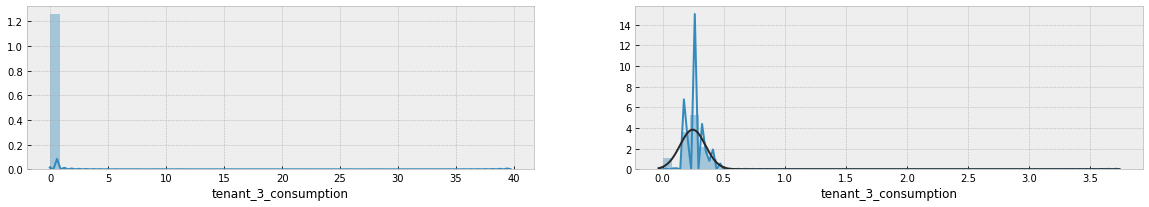

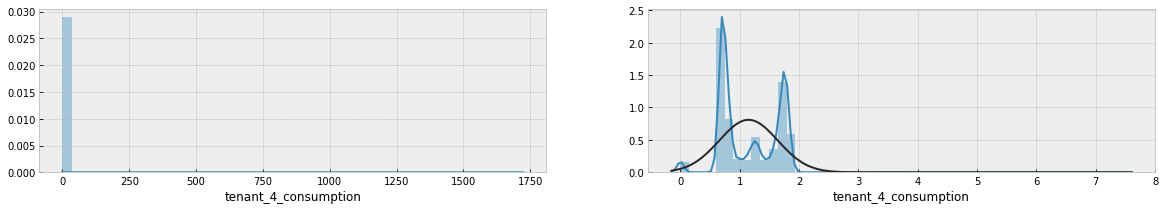

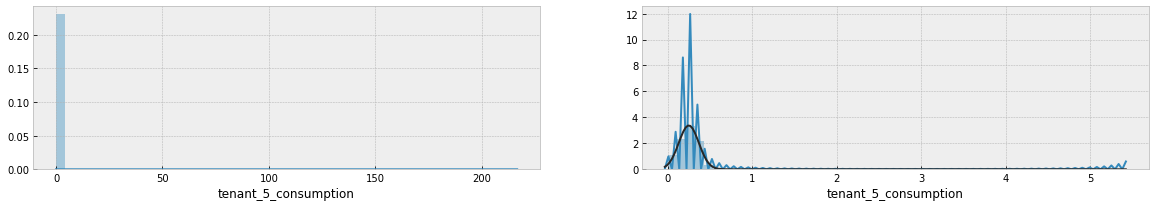

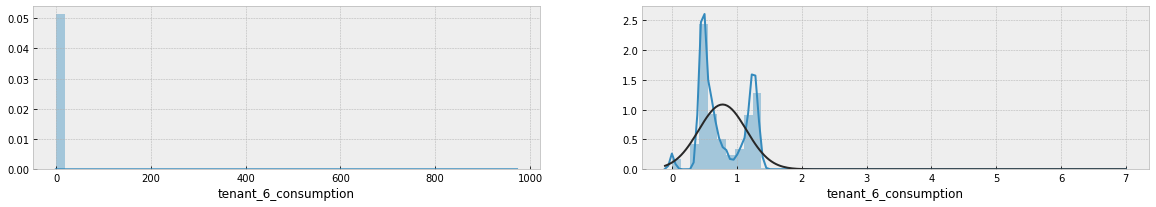

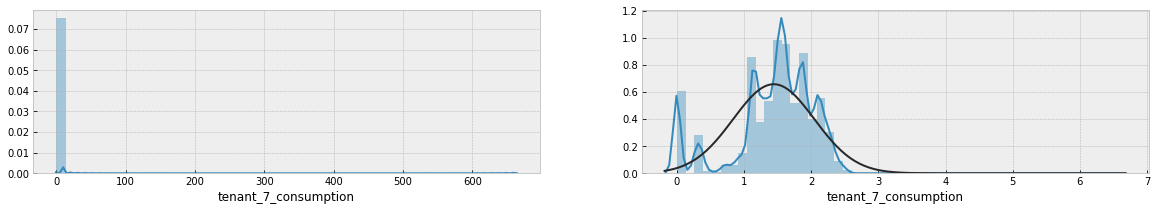

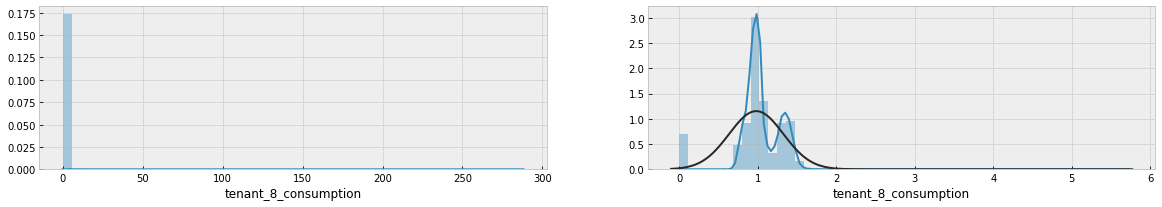

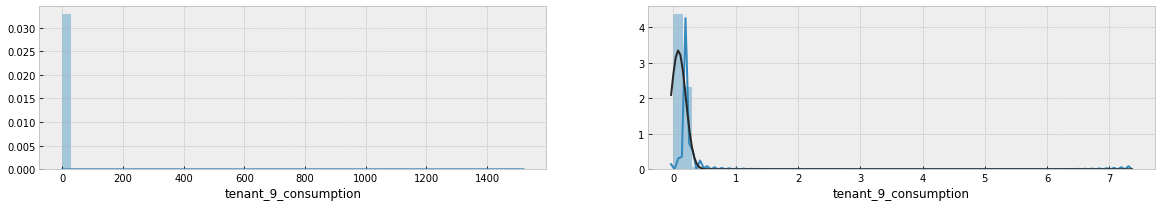

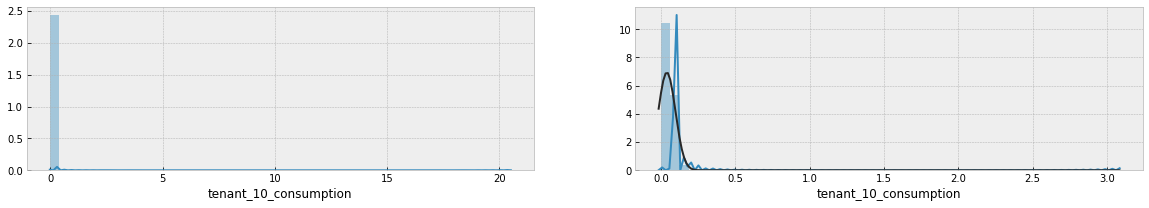

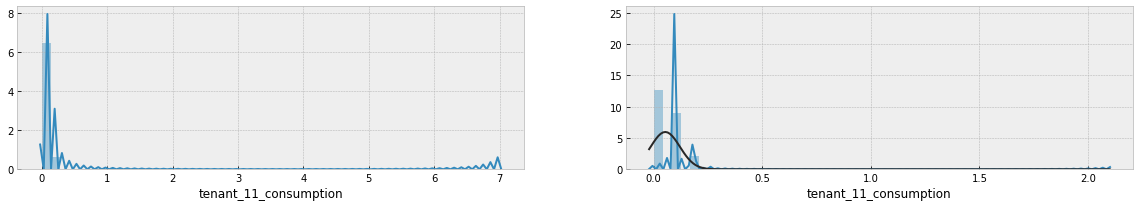

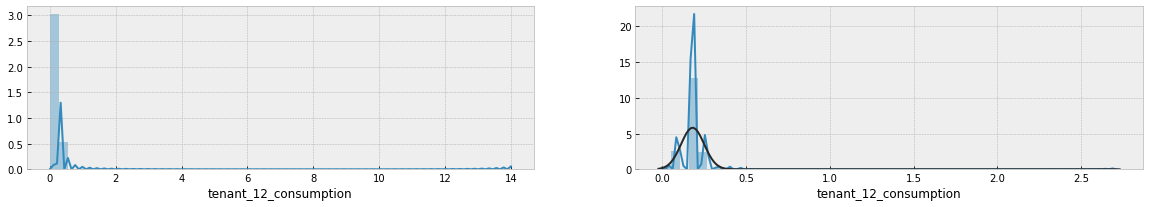

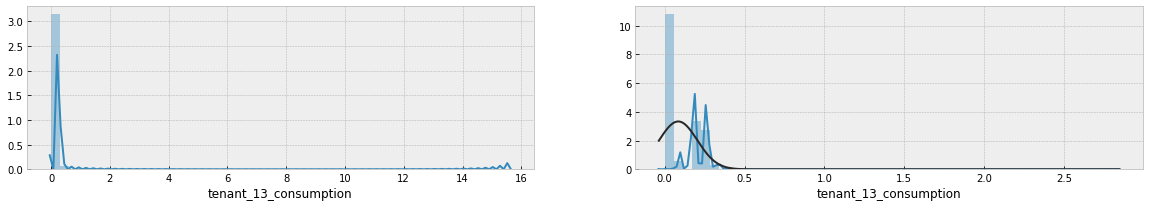

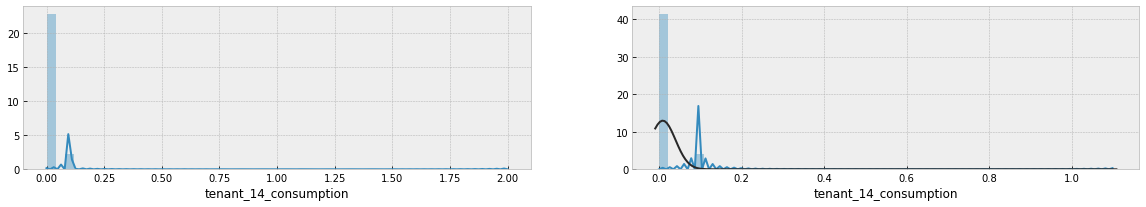

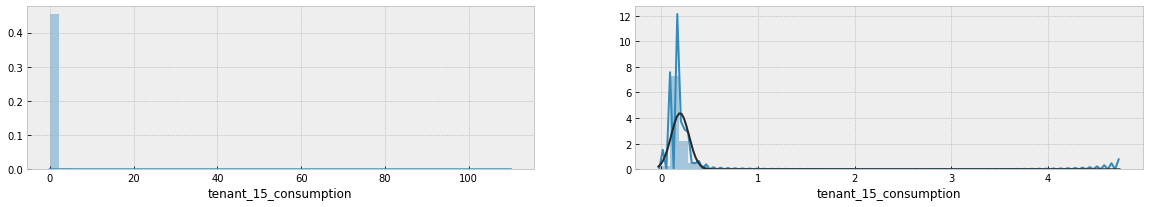

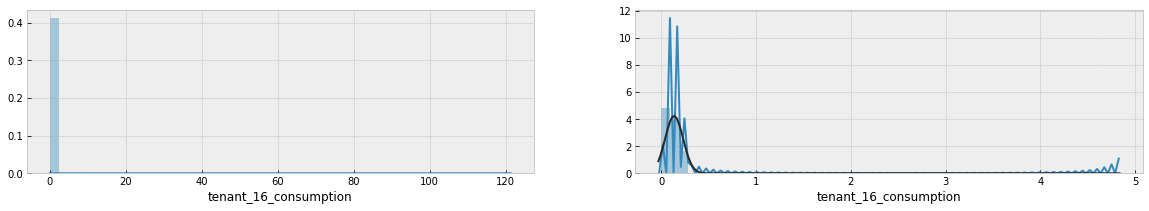

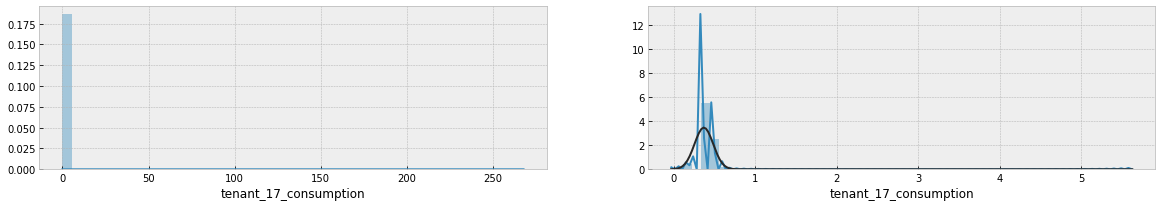

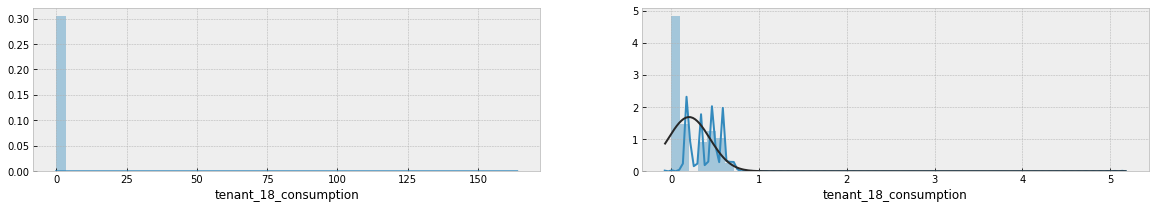

In [219]:
for i in range(1, 19):
    fig, axs = plt.subplots(1,2, figsize=(20,3))
    sns.distplot(merge_data['tenant_'+str(i)+'_consumption'].fillna(0), ax=axs[0])
    sns.distplot(np.log1p(merge_data['tenant_'+str(i)+'_consumption'].fillna(0)), fit=norm, ax=axs[1])
    plt.show()

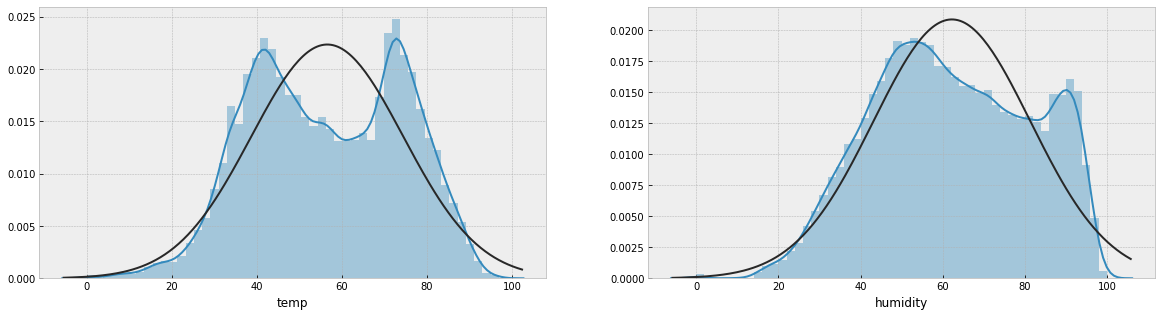

In [221]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
sns.distplot(merge_data['temp'].fillna(0), fit=norm, ax=axs[0])
sns.distplot(merge_data['humidity'].fillna(0), fit=norm, ax=axs[1])
plt.show()